In [353]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [391]:
img_dir = './flickr30k_images/' # dataset

img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

100


In [395]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((294,210))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
        img = mpimg.imread(img_dir+img_list[index])
#         img = (img*256).astype(np.uint8)
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
        return img

In [396]:
batch_size=30
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 294, 210])


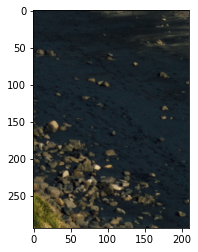

In [397]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[0]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [315]:
IMG_WIDTH = 150
IMG_HEIGHT = 210
latent_size = 200

num_channels_in_encoder = 8

In [9]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),#零填充左1dim，右2dim，上1dim，下2dim
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )
        
        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )
        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [10]:
device

'cpu'

In [11]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print('The Compression Ratio is :  ' + str((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3)*100) )

torch.Size([100, 1, 52, 37])
The Compression Ratio is :  2.035978835978836


In [12]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=256, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )

        
        
    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        # print(dec.shape)
        return dec

In [13]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(100*num_channels_in_encoder*52*37).view((-1,num_channels_in_encoder,52,37)).to(device)
output = netG(inp)
print(output.shape)
#218 * 178

torch.Size([100, 3, 210, 150])


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(num_channels_in_encoder, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )

        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*52*37,2000),
            nn.Sigmoid(),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )
        
        
    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
#         print(y.shape)
        x = x['img'].to(device)
#         print(x.shape)
        x = torch.cat((x,y),1)
        # print(x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*num_channels_in_encoder*52*37).view((-1,num_channels_in_encoder,52,37))
output = netD(inp_x)
output.shape

In [81]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss() # D_loss
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

In [18]:
valid_dataset = ImageData(is_train=False)
num_images_to_show = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=num_images_to_show, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

Starting Training Loop...
[0/9][0/848]	Loss_D: 1.4225	Loss_G: 2.7335	Loss_E: 2.7362	D(x): 0.4077	D(G(z)): 0.4077 / 0.4077


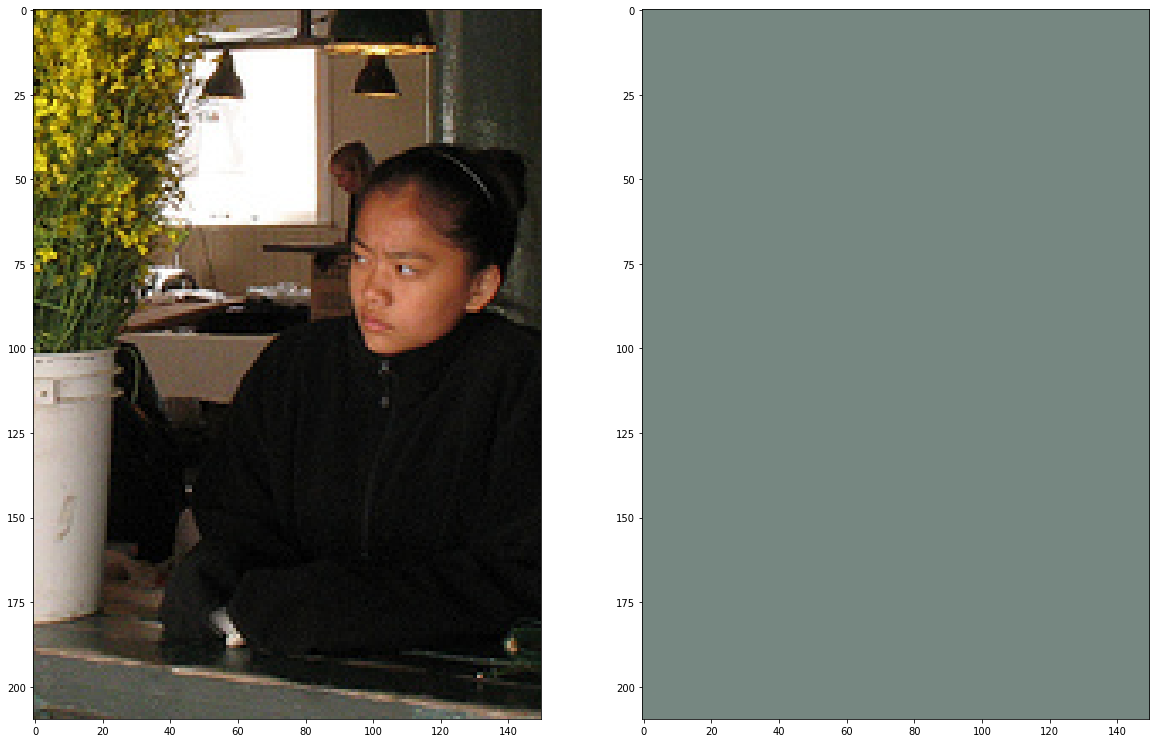

[0/9][50/848]	Loss_D: 1.5096	Loss_G: 1.3979	Loss_E: 1.4018	D(x): 0.7170	D(G(z)): 0.6902 / 0.6902
[0/9][100/848]	Loss_D: 1.4055	Loss_G: 1.2645	Loss_E: 1.2677	D(x): 0.8179	D(G(z)): 0.6763 / 0.6764
[0/9][150/848]	Loss_D: 1.4812	Loss_G: 1.3253	Loss_E: 1.3239	D(x): 0.8459	D(G(z)): 0.7030 / 0.7022
[0/9][200/848]	Loss_D: 1.4860	Loss_G: 1.2179	Loss_E: 1.2262	D(x): 0.7429	D(G(z)): 0.6984 / 0.6985
[0/9][250/848]	Loss_D: 1.4924	Loss_G: 1.3045	Loss_E: 1.3013	D(x): 0.8340	D(G(z)): 0.7123 / 0.7149
[0/9][300/848]	Loss_D: 1.5543	Loss_G: 1.1963	Loss_E: 1.1972	D(x): 0.7541	D(G(z)): 0.7218 / 0.7220
[0/9][350/848]	Loss_D: 1.4980	Loss_G: 1.1313	Loss_E: 1.1237	D(x): 0.7790	D(G(z)): 0.7000 / 0.7007
[0/9][400/848]	Loss_D: 1.4803	Loss_G: 1.0939	Loss_E: 1.0961	D(x): 0.8032	D(G(z)): 0.7005 / 0.7007
[0/9][450/848]	Loss_D: 1.6170	Loss_G: 1.0751	Loss_E: 1.0666	D(x): 0.7422	D(G(z)): 0.7308 / 0.7306
[0/9][500/848]	Loss_D: 1.4915	Loss_G: 1.1846	Loss_E: 1.1938	D(x): 0.7557	D(G(z)): 0.6972 / 0.6976


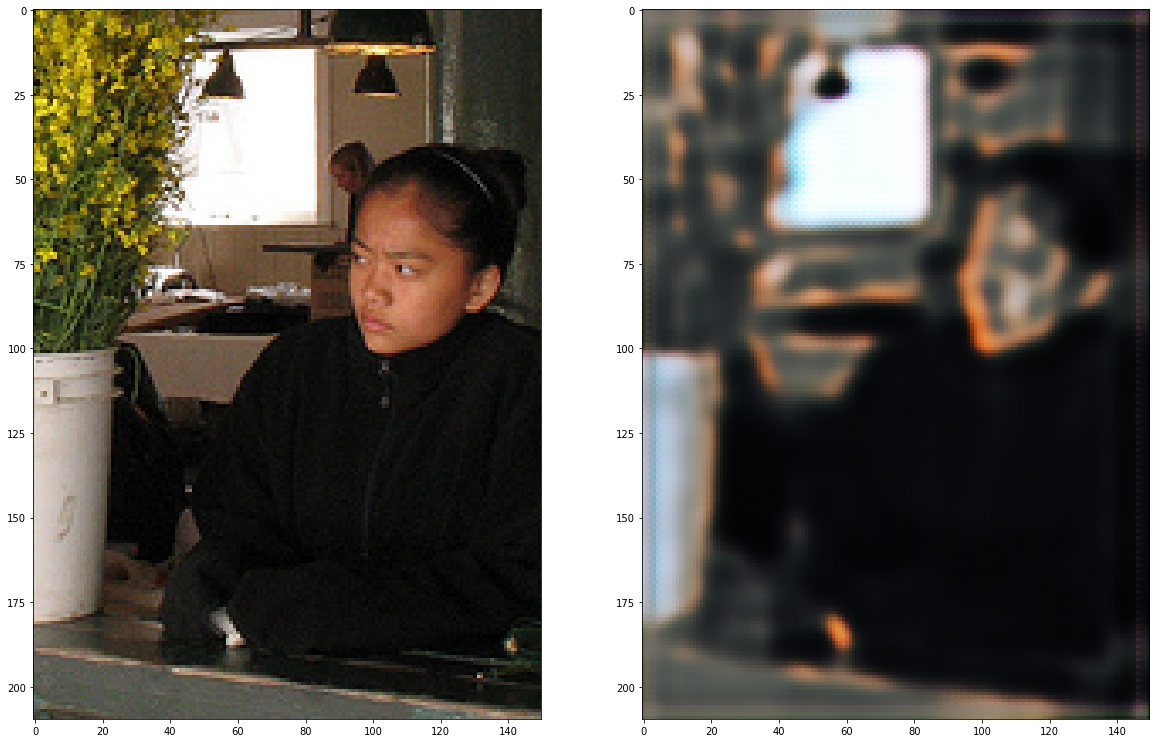

[0/9][550/848]	Loss_D: 1.5878	Loss_G: 1.1464	Loss_E: 1.1327	D(x): 0.7588	D(G(z)): 0.7229 / 0.7230
[0/9][600/848]	Loss_D: 1.4576	Loss_G: 1.1056	Loss_E: 1.1103	D(x): 0.7750	D(G(z)): 0.6881 / 0.6891
[0/9][650/848]	Loss_D: 1.5382	Loss_G: 1.0396	Loss_E: 1.0335	D(x): 0.7450	D(G(z)): 0.7105 / 0.7094
[0/9][700/848]	Loss_D: 1.5157	Loss_G: 1.2715	Loss_E: 1.2624	D(x): 0.7599	D(G(z)): 0.7001 / 0.6995
[0/9][750/848]	Loss_D: 1.4760	Loss_G: 1.0821	Loss_E: 1.0870	D(x): 0.7567	D(G(z)): 0.6878 / 0.6840
[0/9][800/848]	Loss_D: 1.6192	Loss_G: 0.9761	Loss_E: 0.9646	D(x): 0.7280	D(G(z)): 0.7274 / 0.7277
[1/9][0/848]	Loss_D: 1.6054	Loss_G: 0.9920	Loss_E: 0.9952	D(x): 0.7164	D(G(z)): 0.7216 / 0.7224


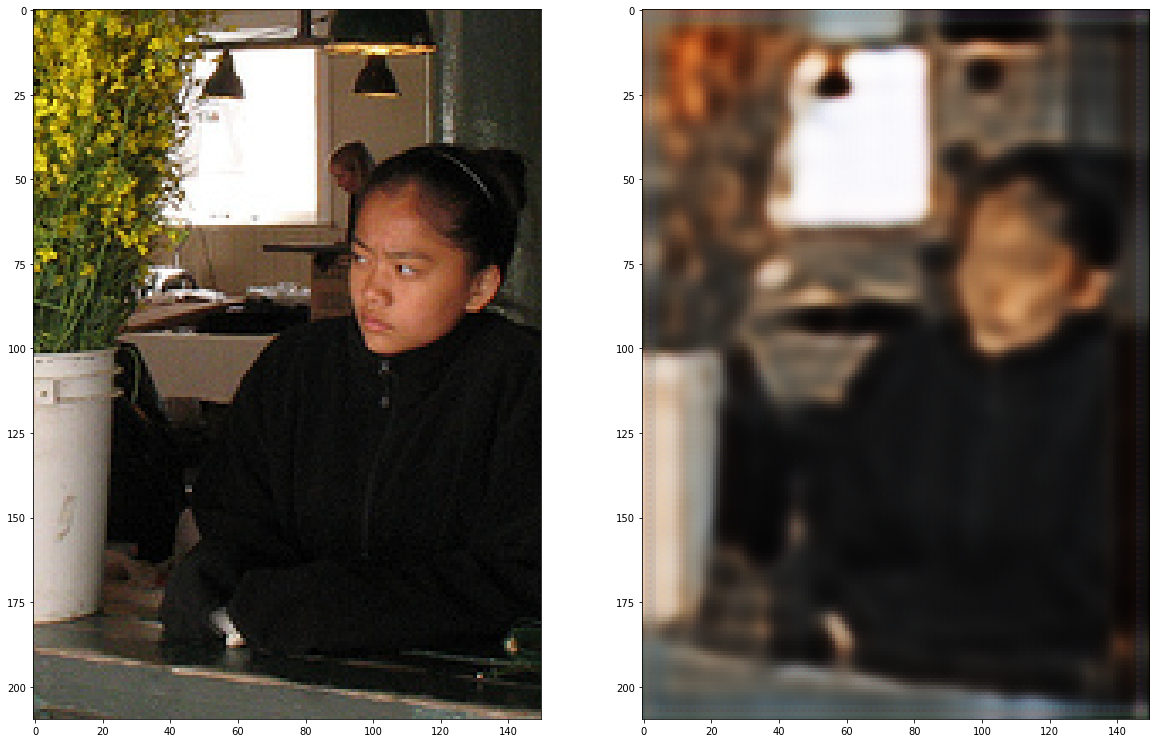

[1/9][50/848]	Loss_D: 1.6045	Loss_G: 1.0521	Loss_E: 1.0461	D(x): 0.7223	D(G(z)): 0.7239 / 0.7237
[1/9][100/848]	Loss_D: 1.6087	Loss_G: 0.9437	Loss_E: 0.9436	D(x): 0.7246	D(G(z)): 0.7250 / 0.7256
[1/9][150/848]	Loss_D: 1.6033	Loss_G: 0.9430	Loss_E: 0.9335	D(x): 0.7289	D(G(z)): 0.7282 / 0.7287
[1/9][200/848]	Loss_D: 1.5926	Loss_G: 0.9499	Loss_E: 0.9457	D(x): 0.7239	D(G(z)): 0.7229 / 0.7227
[1/9][250/848]	Loss_D: 1.6012	Loss_G: 0.8232	Loss_E: 0.8296	D(x): 0.7266	D(G(z)): 0.7272 / 0.7273
[1/9][300/848]	Loss_D: 1.6179	Loss_G: 0.8878	Loss_E: 0.8899	D(x): 0.7255	D(G(z)): 0.7255 / 0.7252
[1/9][350/848]	Loss_D: 1.6285	Loss_G: 0.9170	Loss_E: 0.9243	D(x): 0.7288	D(G(z)): 0.7283 / 0.7286
[1/9][400/848]	Loss_D: 1.5994	Loss_G: 0.8430	Loss_E: 0.8562	D(x): 0.7229	D(G(z)): 0.7232 / 0.7231
[1/9][450/848]	Loss_D: 1.6068	Loss_G: 0.8849	Loss_E: 0.8853	D(x): 0.7230	D(G(z)): 0.7229 / 0.7230
[1/9][500/848]	Loss_D: 1.5974	Loss_G: 0.8799	Loss_E: 0.8730	D(x): 0.7259	D(G(z)): 0.7248 / 0.7251


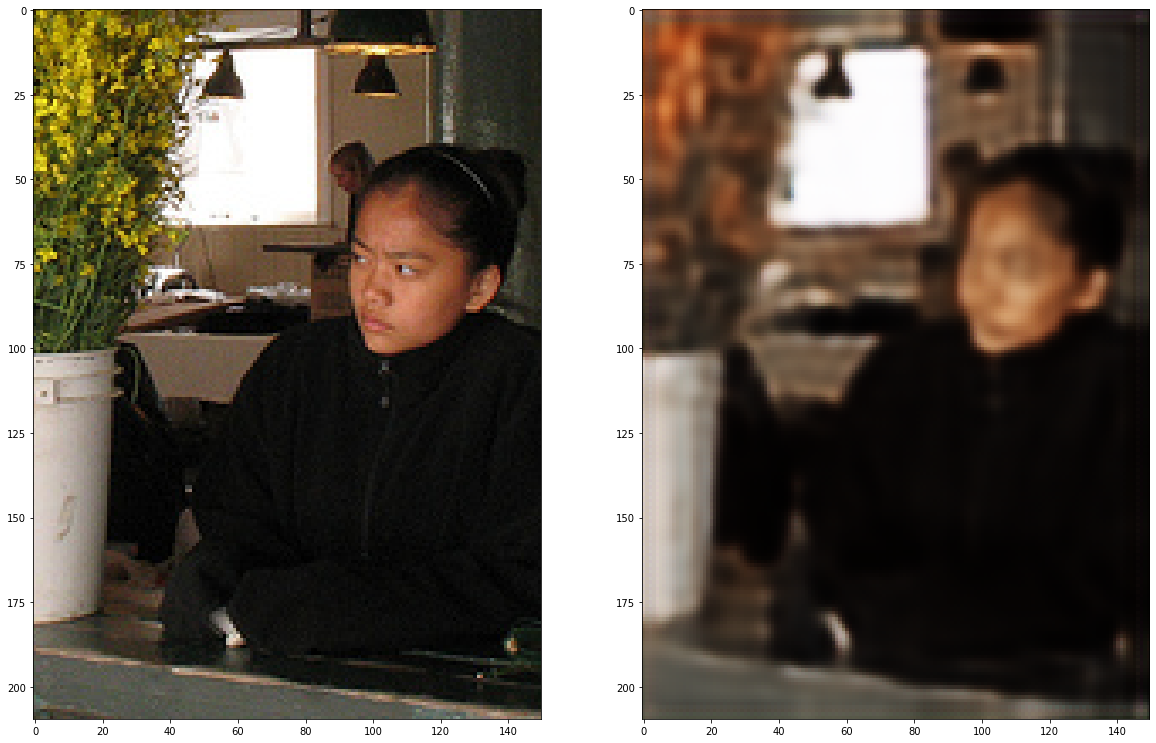

[1/9][550/848]	Loss_D: 1.6182	Loss_G: 0.8943	Loss_E: 0.8860	D(x): 0.7233	D(G(z)): 0.7233 / 0.7229
[1/9][600/848]	Loss_D: 1.5995	Loss_G: 0.8553	Loss_E: 0.8518	D(x): 0.7278	D(G(z)): 0.7276 / 0.7269
[1/9][650/848]	Loss_D: 1.6140	Loss_G: 0.8610	Loss_E: 0.8569	D(x): 0.7263	D(G(z)): 0.7262 / 0.7266
[1/9][700/848]	Loss_D: 1.6030	Loss_G: 0.8920	Loss_E: 0.8914	D(x): 0.7240	D(G(z)): 0.7242 / 0.7239
[1/9][750/848]	Loss_D: 1.6091	Loss_G: 0.8156	Loss_E: 0.8204	D(x): 0.7208	D(G(z)): 0.7210 / 0.7212
[1/9][800/848]	Loss_D: 1.6254	Loss_G: 0.8187	Loss_E: 0.8121	D(x): 0.7278	D(G(z)): 0.7276 / 0.7276
[2/9][0/848]	Loss_D: 1.6288	Loss_G: 0.9196	Loss_E: 0.9110	D(x): 0.7299	D(G(z)): 0.7296 / 0.7294


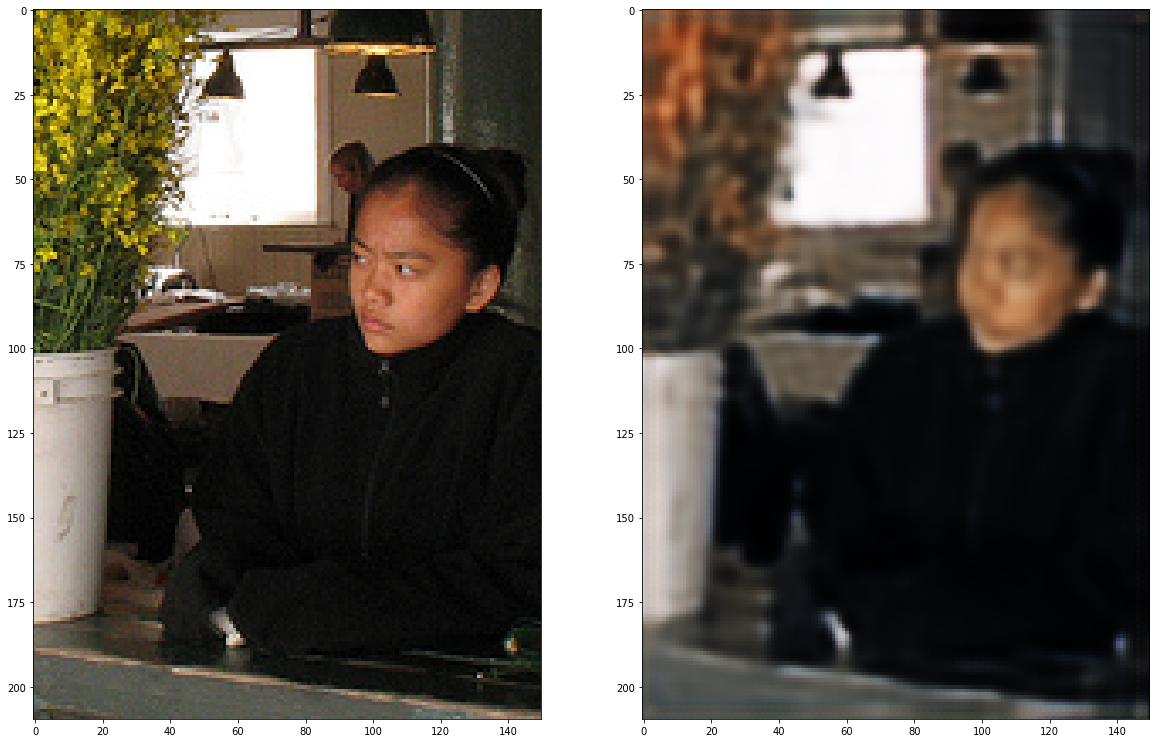

[2/9][50/848]	Loss_D: 1.6155	Loss_G: 0.8971	Loss_E: 0.9050	D(x): 0.7246	D(G(z)): 0.7246 / 0.7243
[2/9][100/848]	Loss_D: 1.6246	Loss_G: 0.8931	Loss_E: 0.8828	D(x): 0.7265	D(G(z)): 0.7259 / 0.7258
[2/9][150/848]	Loss_D: 1.5899	Loss_G: 0.8292	Loss_E: 0.8245	D(x): 0.7229	D(G(z)): 0.7231 / 0.7228
[2/9][200/848]	Loss_D: 1.6128	Loss_G: 0.8301	Loss_E: 0.8185	D(x): 0.7299	D(G(z)): 0.7299 / 0.7299
[2/9][250/848]	Loss_D: 1.6132	Loss_G: 0.8353	Loss_E: 0.8334	D(x): 0.7222	D(G(z)): 0.7224 / 0.7225
[2/9][300/848]	Loss_D: 1.6035	Loss_G: 0.8253	Loss_E: 0.8121	D(x): 0.7284	D(G(z)): 0.7279 / 0.7278
[2/9][350/848]	Loss_D: 1.5947	Loss_G: 0.7800	Loss_E: 0.7928	D(x): 0.7230	D(G(z)): 0.7230 / 0.7230
[2/9][400/848]	Loss_D: 1.6034	Loss_G: 0.8286	Loss_E: 0.8365	D(x): 0.7214	D(G(z)): 0.7218 / 0.7217
[2/9][450/848]	Loss_D: 1.6102	Loss_G: 0.7970	Loss_E: 0.7935	D(x): 0.7262	D(G(z)): 0.7258 / 0.7263
[2/9][500/848]	Loss_D: 1.6015	Loss_G: 0.7398	Loss_E: 0.7463	D(x): 0.7261	D(G(z)): 0.7258 / 0.7258


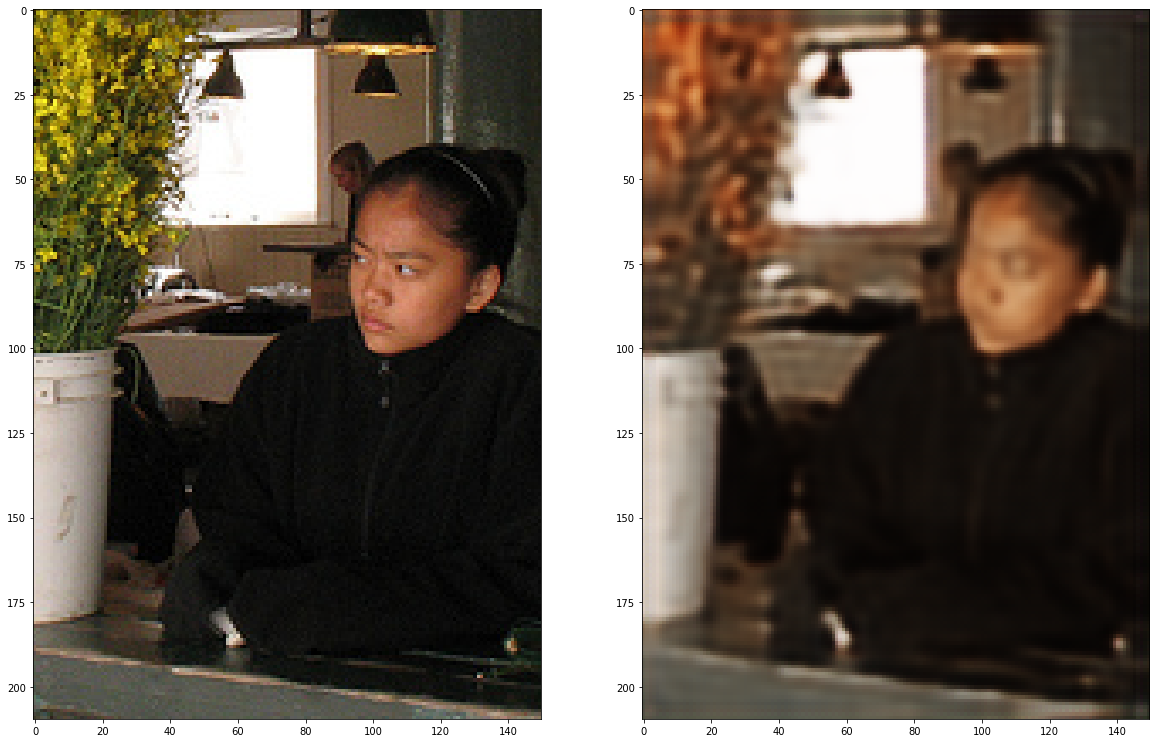

[2/9][550/848]	Loss_D: 1.5921	Loss_G: 0.8116	Loss_E: 0.8013	D(x): 0.7237	D(G(z)): 0.7234 / 0.7233
[2/9][600/848]	Loss_D: 1.6171	Loss_G: 0.8172	Loss_E: 0.8107	D(x): 0.7288	D(G(z)): 0.7286 / 0.7286
[2/9][650/848]	Loss_D: 1.5984	Loss_G: 0.8315	Loss_E: 0.8327	D(x): 0.7249	D(G(z)): 0.7244 / 0.7245
[2/9][700/848]	Loss_D: 1.6016	Loss_G: 0.8047	Loss_E: 0.8021	D(x): 0.7273	D(G(z)): 0.7272 / 0.7272
[2/9][750/848]	Loss_D: 1.6118	Loss_G: 0.8465	Loss_E: 0.8443	D(x): 0.7242	D(G(z)): 0.7239 / 0.7240
[2/9][800/848]	Loss_D: 1.6065	Loss_G: 0.8219	Loss_E: 0.8159	D(x): 0.7288	D(G(z)): 0.7287 / 0.7287
[3/9][0/848]	Loss_D: 1.6065	Loss_G: 0.7957	Loss_E: 0.7955	D(x): 0.7279	D(G(z)): 0.7275 / 0.7277


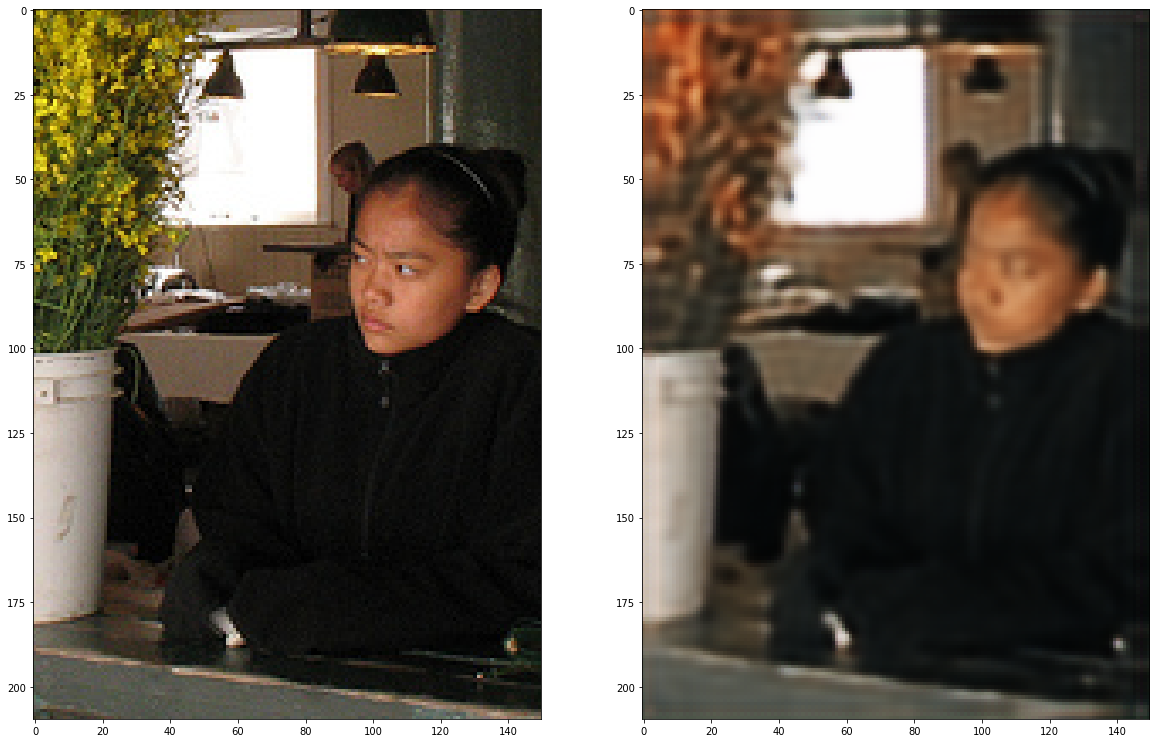

[3/9][50/848]	Loss_D: 1.6156	Loss_G: 0.7767	Loss_E: 0.7729	D(x): 0.7265	D(G(z)): 0.7262 / 0.7263
[3/9][100/848]	Loss_D: 1.6058	Loss_G: 0.7748	Loss_E: 0.7822	D(x): 0.7259	D(G(z)): 0.7258 / 0.7256
[3/9][150/848]	Loss_D: 1.6064	Loss_G: 0.8313	Loss_E: 0.8308	D(x): 0.7261	D(G(z)): 0.7257 / 0.7258
[3/9][200/848]	Loss_D: 1.6037	Loss_G: 0.7969	Loss_E: 0.7921	D(x): 0.7272	D(G(z)): 0.7275 / 0.7276
[3/9][250/848]	Loss_D: 1.5927	Loss_G: 0.8320	Loss_E: 0.8370	D(x): 0.7220	D(G(z)): 0.7213 / 0.7214
[3/9][300/848]	Loss_D: 1.5970	Loss_G: 0.8645	Loss_E: 0.8548	D(x): 0.7231	D(G(z)): 0.7220 / 0.7223
[3/9][350/848]	Loss_D: 1.5964	Loss_G: 0.8111	Loss_E: 0.8125	D(x): 0.7252	D(G(z)): 0.7246 / 0.7245
[3/9][400/848]	Loss_D: 1.5875	Loss_G: 0.8432	Loss_E: 0.8509	D(x): 0.7243	D(G(z)): 0.7228 / 0.7229
[3/9][450/848]	Loss_D: 1.6132	Loss_G: 0.8025	Loss_E: 0.7998	D(x): 0.7321	D(G(z)): 0.7257 / 0.7277
[3/9][500/848]	Loss_D: 1.5734	Loss_G: 0.8226	Loss_E: 0.8189	D(x): 0.7089	D(G(z)): 0.7085 / 0.7085


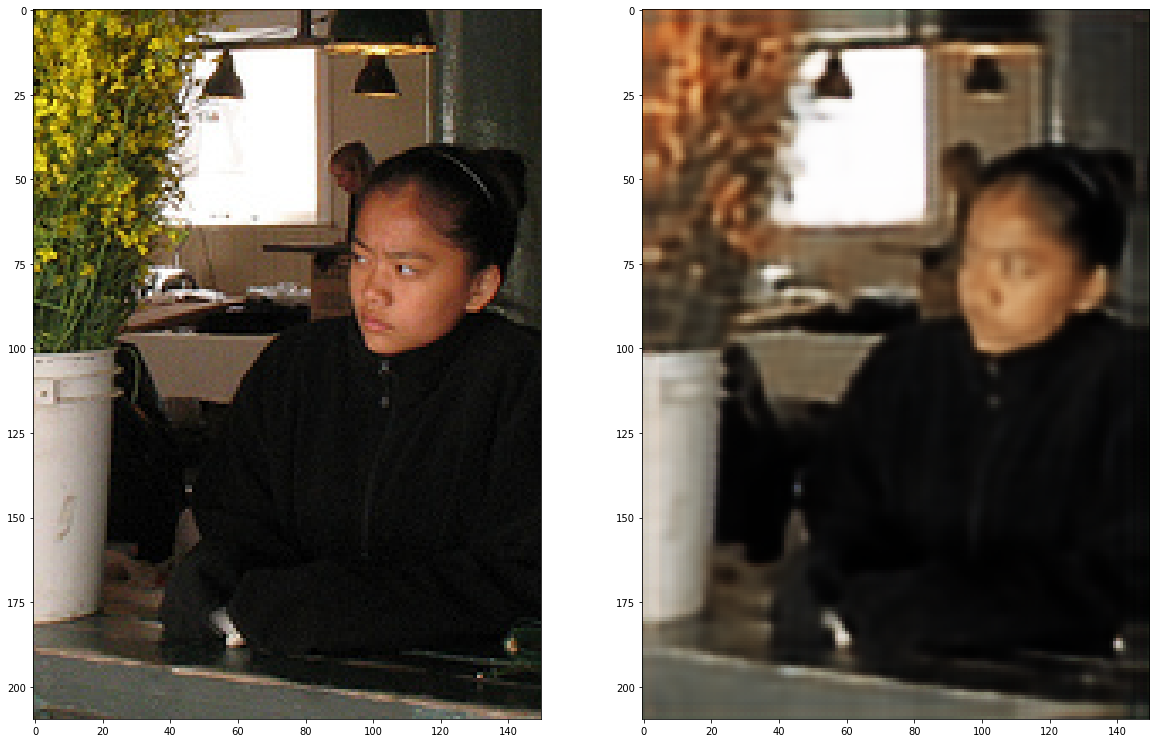

[3/9][550/848]	Loss_D: 1.5407	Loss_G: 0.8176	Loss_E: 0.8182	D(x): 0.7080	D(G(z)): 0.6977 / 0.6977
[3/9][600/848]	Loss_D: 1.6021	Loss_G: 0.8212	Loss_E: 0.8167	D(x): 0.7312	D(G(z)): 0.7224 / 0.7229
[3/9][650/848]	Loss_D: 1.5324	Loss_G: 0.8797	Loss_E: 0.8856	D(x): 0.7272	D(G(z)): 0.7043 / 0.7042
[3/9][700/848]	Loss_D: 1.6076	Loss_G: 1.0267	Loss_E: 1.0360	D(x): 0.6728	D(G(z)): 0.7060 / 0.7068
[3/9][750/848]	Loss_D: 1.6047	Loss_G: 0.7978	Loss_E: 0.8086	D(x): 0.7290	D(G(z)): 0.7279 / 0.7279
[3/9][800/848]	Loss_D: 1.5754	Loss_G: 0.8277	Loss_E: 0.8327	D(x): 0.7334	D(G(z)): 0.7275 / 0.7275
[4/9][0/848]	Loss_D: 1.6047	Loss_G: 0.7941	Loss_E: 0.8020	D(x): 0.7320	D(G(z)): 0.7259 / 0.7256


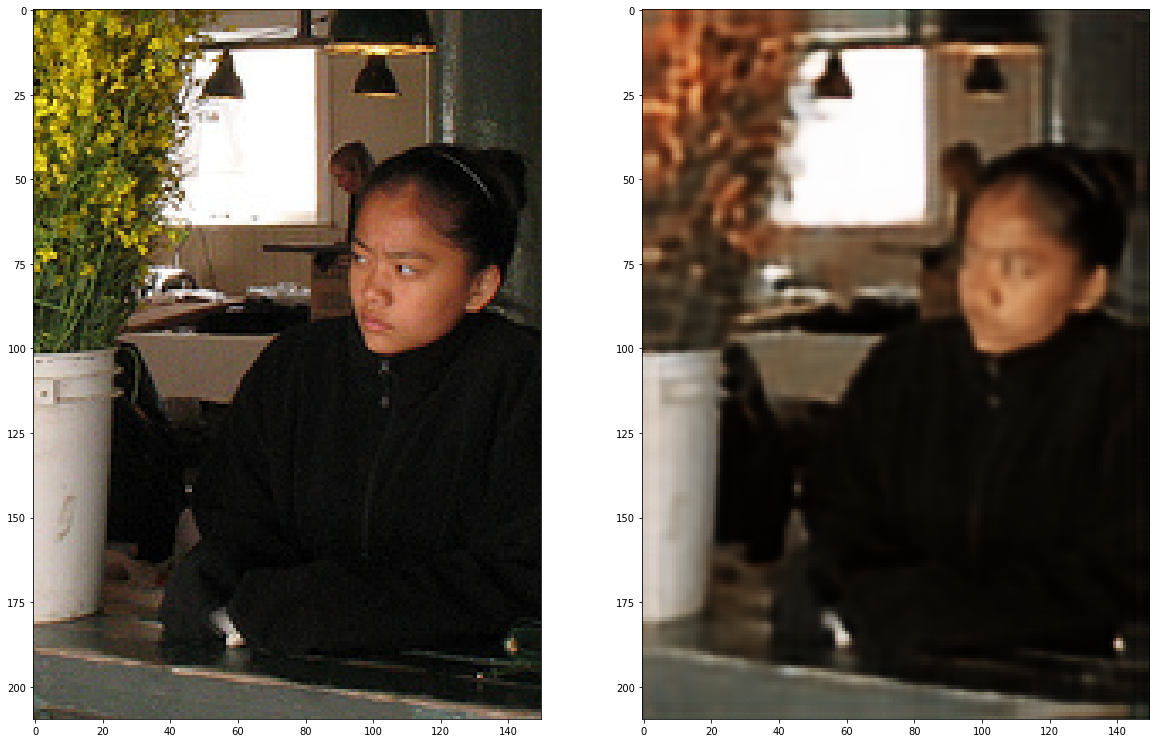

[4/9][50/848]	Loss_D: 1.5939	Loss_G: 0.8004	Loss_E: 0.8025	D(x): 0.7452	D(G(z)): 0.7284 / 0.7293
[4/9][100/848]	Loss_D: 1.7047	Loss_G: 0.8419	Loss_E: 0.8312	D(x): 0.7186	D(G(z)): 0.7442 / 0.7443
[4/9][150/848]	Loss_D: 1.5901	Loss_G: 0.7813	Loss_E: 0.7871	D(x): 0.7365	D(G(z)): 0.7214 / 0.7219
[4/9][200/848]	Loss_D: 1.5631	Loss_G: 0.8161	Loss_E: 0.8124	D(x): 0.7272	D(G(z)): 0.7137 / 0.7141
[4/9][250/848]	Loss_D: 1.5930	Loss_G: 0.7748	Loss_E: 0.7719	D(x): 0.7354	D(G(z)): 0.7225 / 0.7227
[4/9][300/848]	Loss_D: 1.5238	Loss_G: 0.8221	Loss_E: 0.8273	D(x): 0.7589	D(G(z)): 0.7108 / 0.7109
[4/9][350/848]	Loss_D: 1.5717	Loss_G: 0.7742	Loss_E: 0.7759	D(x): 0.7355	D(G(z)): 0.7108 / 0.7095
[4/9][400/848]	Loss_D: 1.5983	Loss_G: 0.7763	Loss_E: 0.7770	D(x): 0.7221	D(G(z)): 0.7224 / 0.7223
[4/9][450/848]	Loss_D: 1.5813	Loss_G: 0.7545	Loss_E: 0.7546	D(x): 0.7301	D(G(z)): 0.7195 / 0.7190
[4/9][500/848]	Loss_D: 1.5178	Loss_G: 0.8195	Loss_E: 0.8241	D(x): 0.7756	D(G(z)): 0.7145 / 0.7154


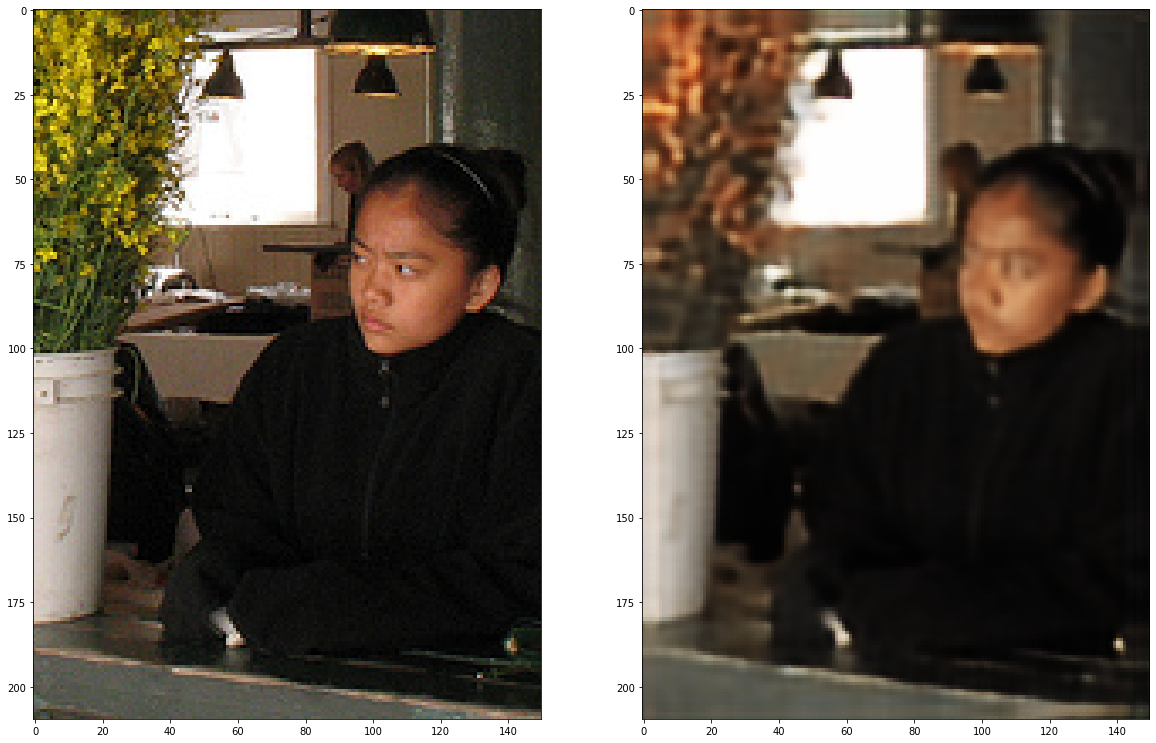

[4/9][550/848]	Loss_D: 1.5674	Loss_G: 0.7578	Loss_E: 0.7538	D(x): 0.7226	D(G(z)): 0.7121 / 0.7122
[4/9][600/848]	Loss_D: 1.5962	Loss_G: 0.8081	Loss_E: 0.8273	D(x): 0.7226	D(G(z)): 0.7248 / 0.7249
[4/9][650/848]	Loss_D: 1.6021	Loss_G: 0.7957	Loss_E: 0.7936	D(x): 0.7300	D(G(z)): 0.7271 / 0.7269
[4/9][700/848]	Loss_D: 1.6418	Loss_G: 0.7602	Loss_E: 0.7637	D(x): 0.7296	D(G(z)): 0.7295 / 0.7296
[4/9][750/848]	Loss_D: 1.6480	Loss_G: 0.8042	Loss_E: 0.7799	D(x): 0.7295	D(G(z)): 0.7331 / 0.7332
[4/9][800/848]	Loss_D: 1.5996	Loss_G: 0.7826	Loss_E: 0.7814	D(x): 0.7232	D(G(z)): 0.7225 / 0.7226
[5/9][0/848]	Loss_D: 1.6201	Loss_G: 0.8274	Loss_E: 0.8192	D(x): 0.7293	D(G(z)): 0.7312 / 0.7310


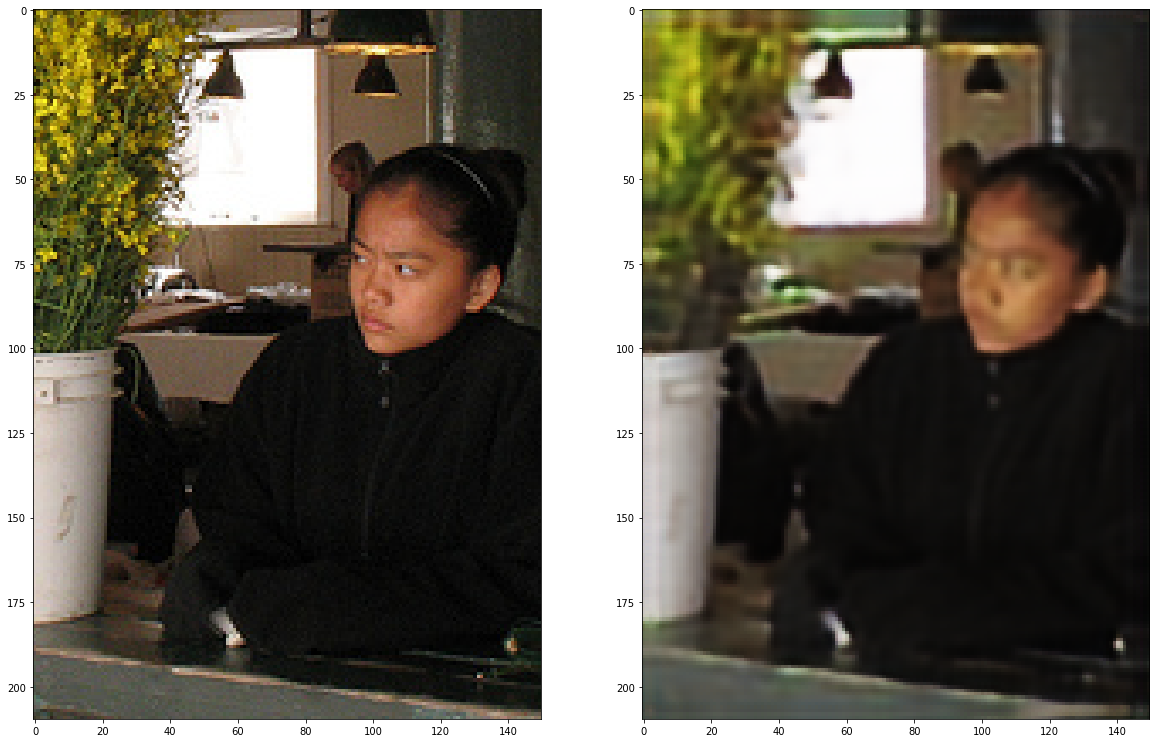

[5/9][50/848]	Loss_D: 1.6297	Loss_G: 0.7655	Loss_E: 0.7762	D(x): 0.7319	D(G(z)): 0.7299 / 0.7296
[5/9][100/848]	Loss_D: 1.6129	Loss_G: 0.7093	Loss_E: 0.7183	D(x): 0.7281	D(G(z)): 0.7222 / 0.7227
[5/9][150/848]	Loss_D: 1.6182	Loss_G: 0.7830	Loss_E: 0.7748	D(x): 0.7346	D(G(z)): 0.7302 / 0.7308
[5/9][200/848]	Loss_D: 1.5773	Loss_G: 0.7673	Loss_E: 0.7643	D(x): 0.7473	D(G(z)): 0.7174 / 0.7171
[5/9][250/848]	Loss_D: 1.6458	Loss_G: 0.7476	Loss_E: 0.7433	D(x): 0.7498	D(G(z)): 0.7440 / 0.7440
[5/9][300/848]	Loss_D: 1.5172	Loss_G: 0.7329	Loss_E: 0.7295	D(x): 0.7445	D(G(z)): 0.7055 / 0.7057
[5/9][350/848]	Loss_D: 1.4970	Loss_G: 0.8518	Loss_E: 0.8556	D(x): 0.7647	D(G(z)): 0.7048 / 0.7045
[5/9][400/848]	Loss_D: 1.5194	Loss_G: 0.8534	Loss_E: 0.8447	D(x): 0.7430	D(G(z)): 0.6994 / 0.6993
[5/9][450/848]	Loss_D: 1.6416	Loss_G: 0.7133	Loss_E: 0.7279	D(x): 0.7795	D(G(z)): 0.7465 / 0.7469
[5/9][500/848]	Loss_D: 1.5499	Loss_G: 0.7391	Loss_E: 0.7423	D(x): 0.7420	D(G(z)): 0.7148 / 0.7150


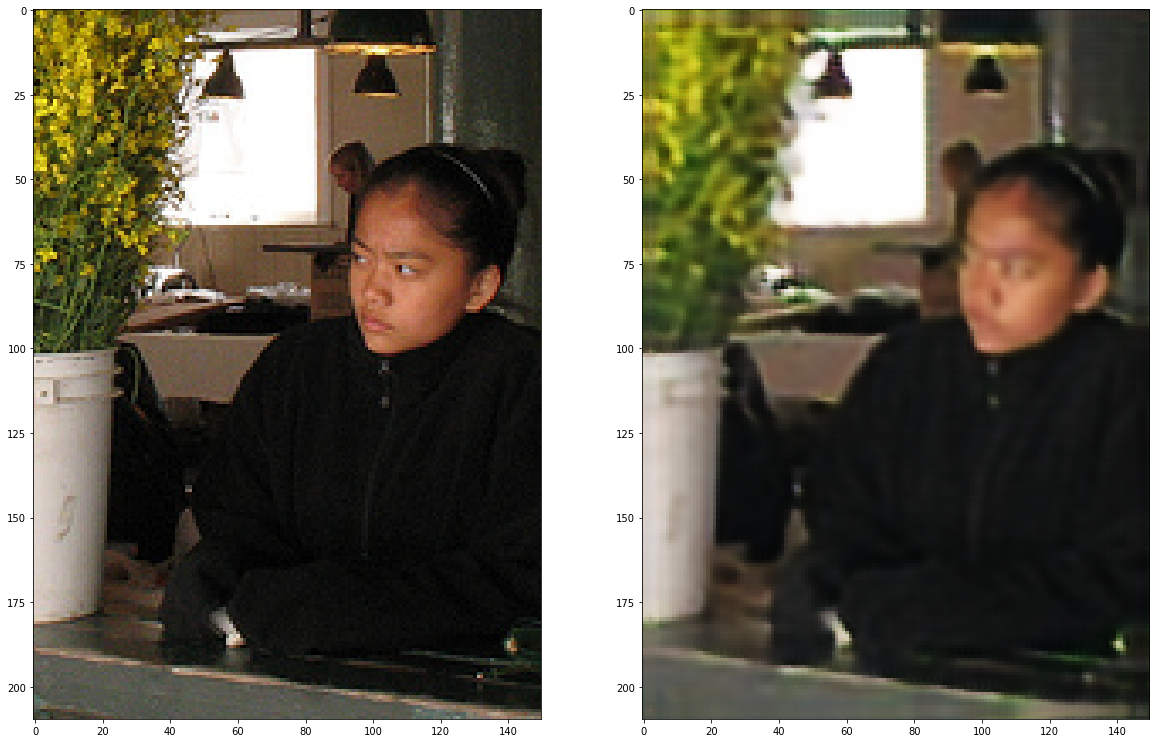

[5/9][550/848]	Loss_D: 1.5673	Loss_G: 0.7597	Loss_E: 0.7746	D(x): 0.7906	D(G(z)): 0.7342 / 0.7321
[5/9][600/848]	Loss_D: 1.5428	Loss_G: 0.7583	Loss_E: 0.7430	D(x): 0.7418	D(G(z)): 0.7093 / 0.7091
[5/9][650/848]	Loss_D: 1.5881	Loss_G: 0.7597	Loss_E: 0.7670	D(x): 0.7859	D(G(z)): 0.7380 / 0.7379
[5/9][700/848]	Loss_D: 1.5424	Loss_G: 0.7016	Loss_E: 0.7030	D(x): 0.7657	D(G(z)): 0.7160 / 0.7162
[5/9][750/848]	Loss_D: 1.5200	Loss_G: 0.7727	Loss_E: 0.7767	D(x): 0.7417	D(G(z)): 0.7057 / 0.7064
[5/9][800/848]	Loss_D: 1.6051	Loss_G: 0.7515	Loss_E: 0.7474	D(x): 0.7528	D(G(z)): 0.7299 / 0.7305
[6/9][0/848]	Loss_D: 1.5774	Loss_G: 0.7857	Loss_E: 0.7784	D(x): 0.7238	D(G(z)): 0.7097 / 0.7098


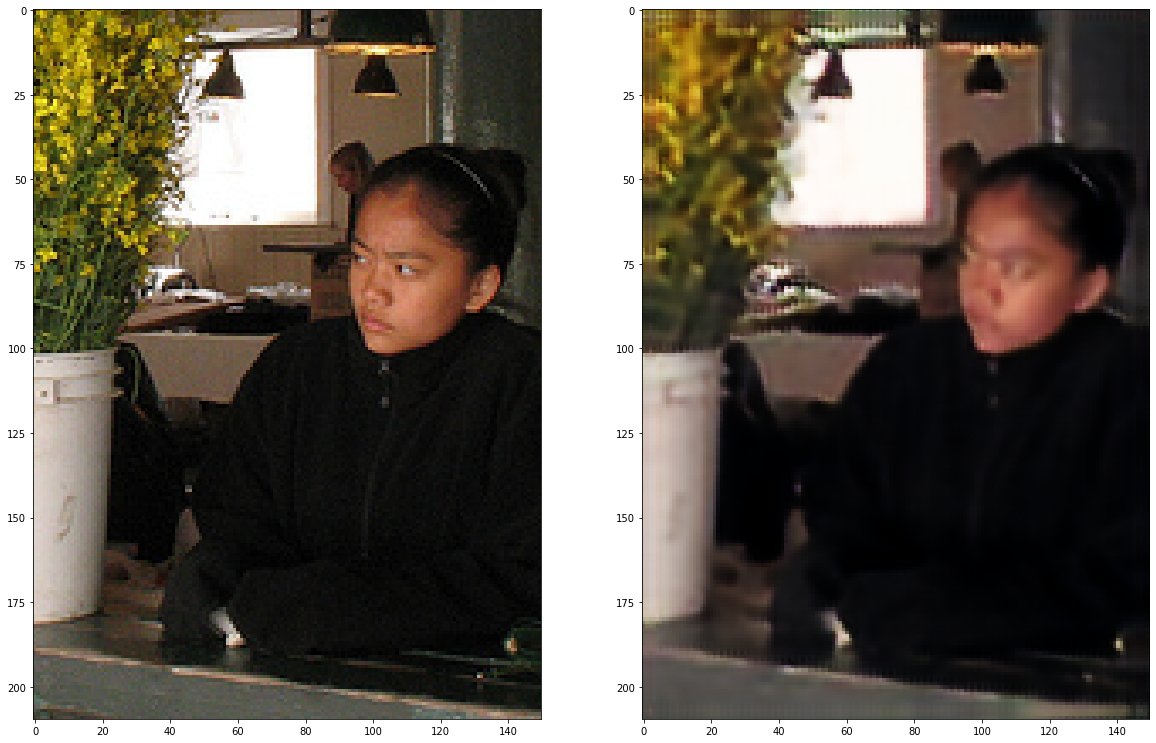

[6/9][50/848]	Loss_D: 1.6275	Loss_G: 0.7308	Loss_E: 0.7287	D(x): 0.7948	D(G(z)): 0.7439 / 0.7426
[6/9][100/848]	Loss_D: 1.5261	Loss_G: 0.7614	Loss_E: 0.7600	D(x): 0.7311	D(G(z)): 0.7007 / 0.7007
[6/9][150/848]	Loss_D: 1.5252	Loss_G: 0.8043	Loss_E: 0.8130	D(x): 0.7147	D(G(z)): 0.6993 / 0.6995
[6/9][200/848]	Loss_D: 1.5912	Loss_G: 0.7885	Loss_E: 0.7915	D(x): 0.7326	D(G(z)): 0.7193 / 0.7177
[6/9][250/848]	Loss_D: 1.4867	Loss_G: 0.7583	Loss_E: 0.7592	D(x): 0.7193	D(G(z)): 0.6832 / 0.6826
[6/9][300/848]	Loss_D: 1.5778	Loss_G: 0.7470	Loss_E: 0.7431	D(x): 0.7162	D(G(z)): 0.7100 / 0.7100
[6/9][350/848]	Loss_D: 1.5947	Loss_G: 0.8184	Loss_E: 0.8088	D(x): 0.7205	D(G(z)): 0.7183 / 0.7181
[6/9][400/848]	Loss_D: 1.5617	Loss_G: 0.7504	Loss_E: 0.7489	D(x): 0.7302	D(G(z)): 0.7102 / 0.7101
[6/9][450/848]	Loss_D: 1.6199	Loss_G: 0.7461	Loss_E: 0.7603	D(x): 0.7552	D(G(z)): 0.7382 / 0.7373
[6/9][500/848]	Loss_D: 1.5455	Loss_G: 0.7048	Loss_E: 0.7011	D(x): 0.7864	D(G(z)): 0.7152 / 0.7148


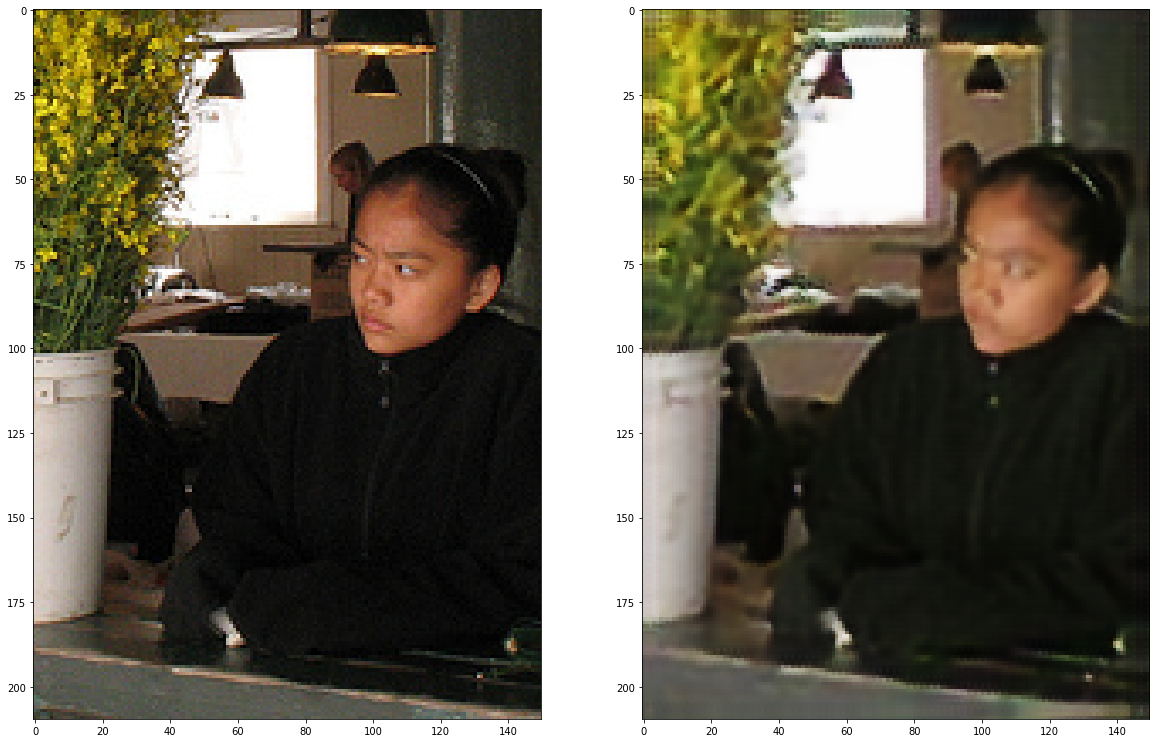

[6/9][550/848]	Loss_D: 1.5677	Loss_G: 0.7163	Loss_E: 0.7245	D(x): 0.7393	D(G(z)): 0.7108 / 0.7109
[6/9][600/848]	Loss_D: 1.5190	Loss_G: 0.7561	Loss_E: 0.7529	D(x): 0.7425	D(G(z)): 0.7033 / 0.7030
[6/9][650/848]	Loss_D: 1.5730	Loss_G: 0.7662	Loss_E: 0.7688	D(x): 0.7801	D(G(z)): 0.7300 / 0.7297
[6/9][700/848]	Loss_D: 1.5434	Loss_G: 0.7283	Loss_E: 0.7415	D(x): 0.7555	D(G(z)): 0.7164 / 0.7165
[6/9][750/848]	Loss_D: 1.5736	Loss_G: 0.7115	Loss_E: 0.7086	D(x): 0.7885	D(G(z)): 0.7287 / 0.7290
[6/9][800/848]	Loss_D: 1.5274	Loss_G: 0.8131	Loss_E: 0.8104	D(x): 0.7027	D(G(z)): 0.6918 / 0.6911
[7/9][0/848]	Loss_D: 1.5399	Loss_G: 0.7466	Loss_E: 0.7356	D(x): 0.7965	D(G(z)): 0.7190 / 0.7182


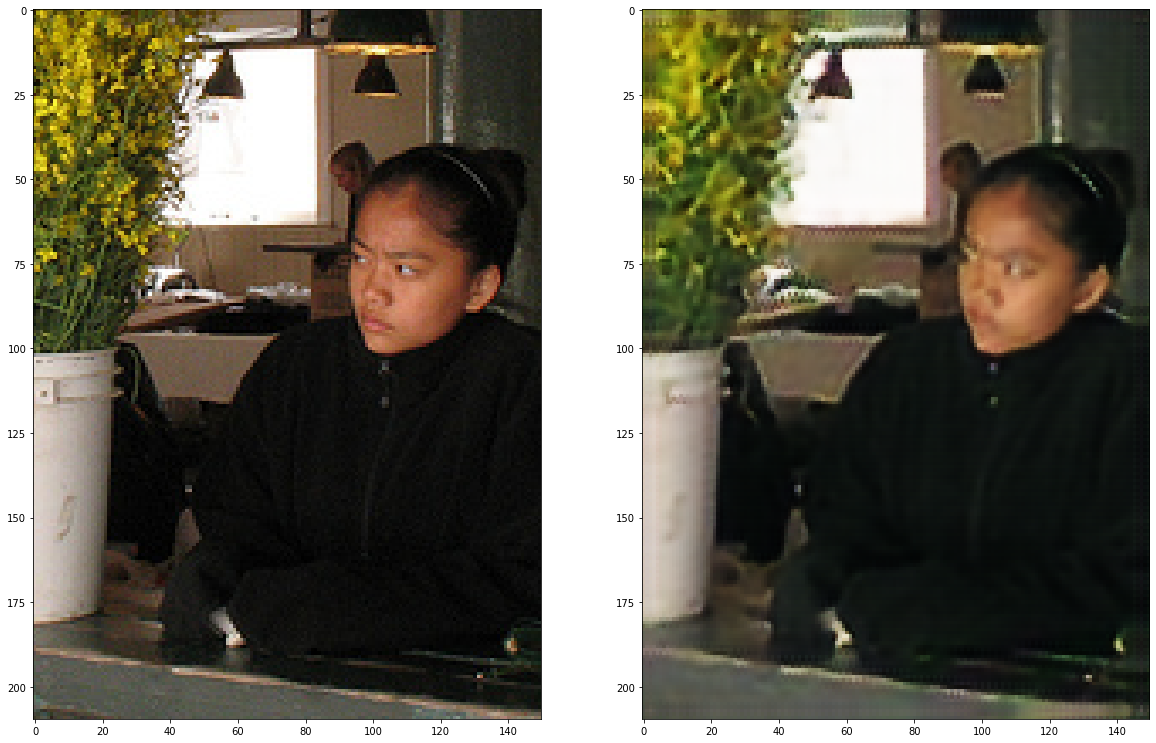

[7/9][50/848]	Loss_D: 1.5803	Loss_G: 0.6921	Loss_E: 0.6928	D(x): 0.8036	D(G(z)): 0.7337 / 0.7337
[7/9][100/848]	Loss_D: 1.5462	Loss_G: 0.7546	Loss_E: 0.7476	D(x): 0.7336	D(G(z)): 0.7059 / 0.7059
[7/9][150/848]	Loss_D: 1.5438	Loss_G: 0.8093	Loss_E: 0.8144	D(x): 0.7193	D(G(z)): 0.7005 / 0.7010
[7/9][200/848]	Loss_D: 1.5140	Loss_G: 0.7688	Loss_E: 0.7621	D(x): 0.8104	D(G(z)): 0.7197 / 0.7202
[7/9][250/848]	Loss_D: 1.5903	Loss_G: 0.7054	Loss_E: 0.7128	D(x): 0.7392	D(G(z)): 0.7241 / 0.7241
[7/9][300/848]	Loss_D: 1.5101	Loss_G: 0.7626	Loss_E: 0.7577	D(x): 0.7643	D(G(z)): 0.7060 / 0.7062
[7/9][350/848]	Loss_D: 1.5454	Loss_G: 0.7426	Loss_E: 0.7608	D(x): 0.7516	D(G(z)): 0.7089 / 0.7093
[7/9][400/848]	Loss_D: 1.5650	Loss_G: 0.7418	Loss_E: 0.7374	D(x): 0.7574	D(G(z)): 0.7130 / 0.7129
[7/9][450/848]	Loss_D: 1.5547	Loss_G: 0.7396	Loss_E: 0.7228	D(x): 0.7973	D(G(z)): 0.7234 / 0.7233
[7/9][500/848]	Loss_D: 1.6006	Loss_G: 0.8372	Loss_E: 0.8551	D(x): 0.7474	D(G(z)): 0.7256 / 0.7259


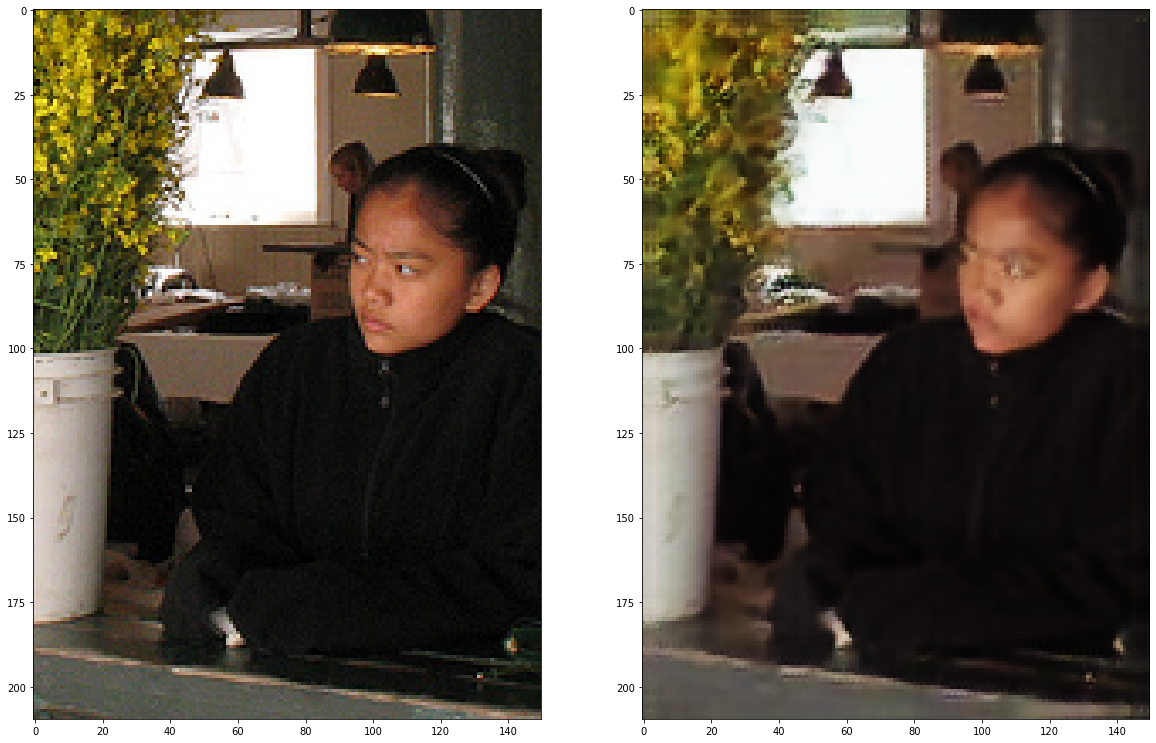

[7/9][550/848]	Loss_D: 1.5641	Loss_G: 0.8021	Loss_E: 0.8092	D(x): 0.7217	D(G(z)): 0.7015 / 0.7021
[7/9][600/848]	Loss_D: 1.5763	Loss_G: 0.7354	Loss_E: 0.7328	D(x): 0.7804	D(G(z)): 0.7287 / 0.7283
[7/9][650/848]	Loss_D: 1.5335	Loss_G: 0.7945	Loss_E: 0.7818	D(x): 0.7191	D(G(z)): 0.7010 / 0.7007
[7/9][700/848]	Loss_D: 1.5671	Loss_G: 0.7836	Loss_E: 0.7806	D(x): 0.7042	D(G(z)): 0.7001 / 0.7003
[7/9][750/848]	Loss_D: 1.5268	Loss_G: 0.7552	Loss_E: 0.7480	D(x): 0.7801	D(G(z)): 0.7131 / 0.7131
[7/9][800/848]	Loss_D: 1.5682	Loss_G: 0.7505	Loss_E: 0.7427	D(x): 0.7618	D(G(z)): 0.7211 / 0.7213
[8/9][0/848]	Loss_D: 1.5511	Loss_G: 0.7071	Loss_E: 0.7084	D(x): 0.7453	D(G(z)): 0.7093 / 0.7097


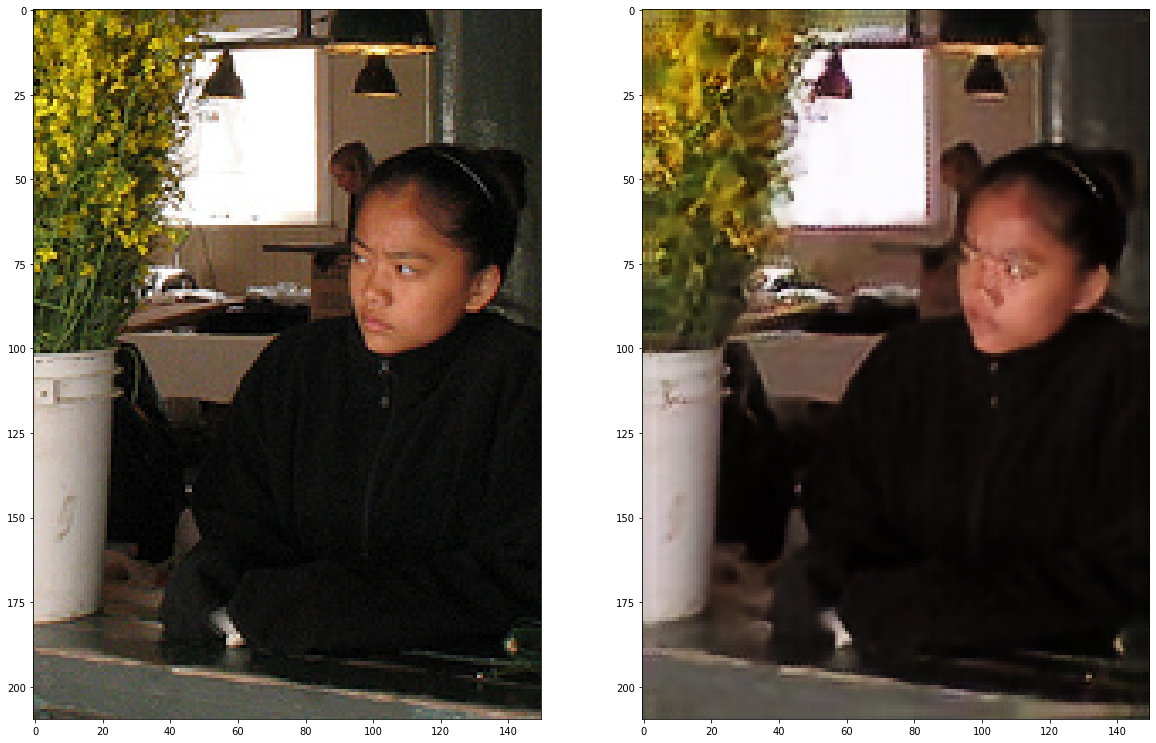

[8/9][50/848]	Loss_D: 1.5349	Loss_G: 0.7748	Loss_E: 0.7621	D(x): 0.7260	D(G(z)): 0.7085 / 0.7085
[8/9][100/848]	Loss_D: 1.6065	Loss_G: 0.6925	Loss_E: 0.6935	D(x): 0.7716	D(G(z)): 0.7387 / 0.7385
[8/9][150/848]	Loss_D: 1.5706	Loss_G: 0.7296	Loss_E: 0.7206	D(x): 0.7117	D(G(z)): 0.7070 / 0.7070
[8/9][200/848]	Loss_D: 1.4910	Loss_G: 0.7957	Loss_E: 0.7931	D(x): 0.7725	D(G(z)): 0.7066 / 0.7063
[8/9][250/848]	Loss_D: 1.6492	Loss_G: 0.7782	Loss_E: 0.7785	D(x): 0.7095	D(G(z)): 0.7297 / 0.7304
[8/9][300/848]	Loss_D: 1.5236	Loss_G: 0.7368	Loss_E: 0.7269	D(x): 0.7818	D(G(z)): 0.7144 / 0.7146
[8/9][350/848]	Loss_D: 1.5311	Loss_G: 0.8125	Loss_E: 0.8264	D(x): 0.7476	D(G(z)): 0.7052 / 0.7052
[8/9][400/848]	Loss_D: 1.5482	Loss_G: 0.6930	Loss_E: 0.6938	D(x): 0.7355	D(G(z)): 0.7052 / 0.7052
[8/9][450/848]	Loss_D: 1.5471	Loss_G: 0.7185	Loss_E: 0.7140	D(x): 0.7658	D(G(z)): 0.7186 / 0.7193
[8/9][500/848]	Loss_D: 1.5571	Loss_G: 0.7202	Loss_E: 0.7331	D(x): 0.7390	D(G(z)): 0.7122 / 0.7124


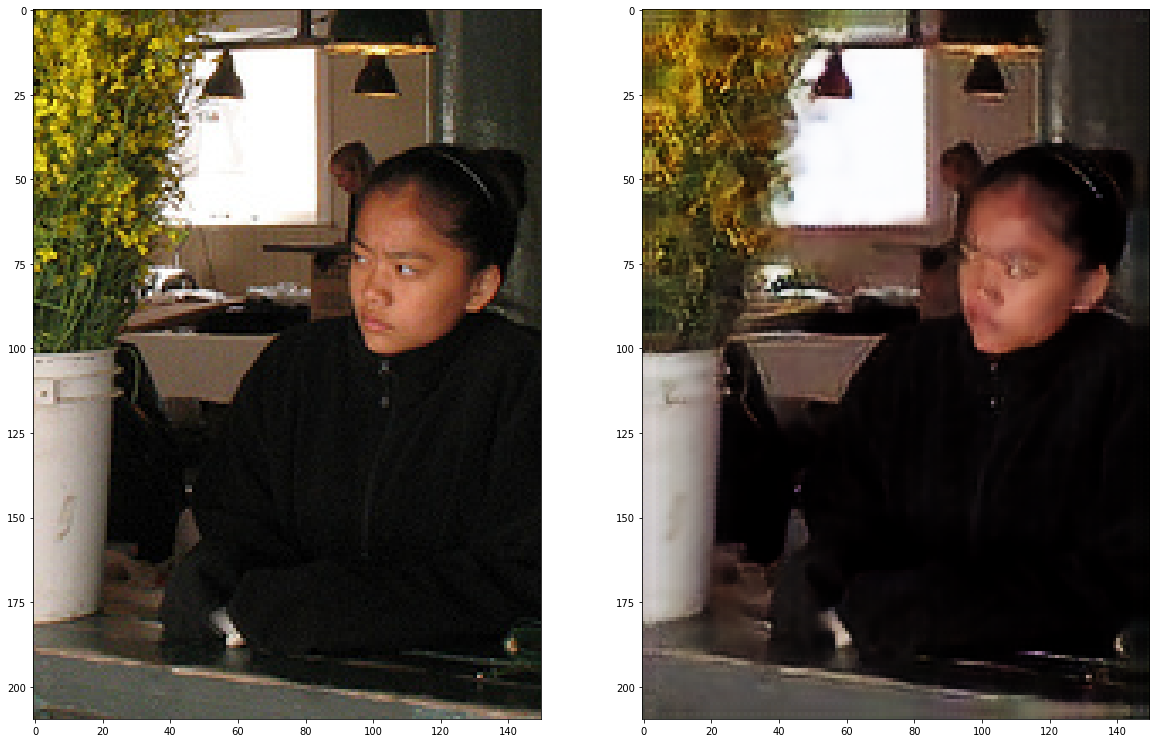

[8/9][550/848]	Loss_D: 1.5961	Loss_G: 0.7548	Loss_E: 0.7630	D(x): 0.7444	D(G(z)): 0.7229 / 0.7223
[8/9][600/848]	Loss_D: 1.5433	Loss_G: 0.7017	Loss_E: 0.7092	D(x): 0.7294	D(G(z)): 0.7080 / 0.7081
[8/9][650/848]	Loss_D: 1.5776	Loss_G: 0.6743	Loss_E: 0.6779	D(x): 0.7904	D(G(z)): 0.7317 / 0.7314
[8/9][700/848]	Loss_D: 1.6038	Loss_G: 0.7332	Loss_E: 0.7196	D(x): 0.7872	D(G(z)): 0.7408 / 0.7414
[8/9][750/848]	Loss_D: 1.5591	Loss_G: 0.7097	Loss_E: 0.7117	D(x): 0.7270	D(G(z)): 0.7143 / 0.7143
[8/9][800/848]	Loss_D: 1.5573	Loss_G: 0.6982	Loss_E: 0.6939	D(x): 0.7716	D(G(z)): 0.7207 / 0.7210


In [19]:
#### Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 9

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()
        
        netD.zero_grad()
        
        images = images.to(device)
        fake_images = netG(netE(images))
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Create a fake pair batch --

        inp_x = {}
        inp_x['img']=images
        inp_x['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()
        
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
        
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        
        errG = criterion(output, label) + 4*l1criterion(images,fake_images) # BCE+L1
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()

        
        netE.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        
        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)

        errE = criterion(output, label) + 4*l1criterion(images,fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        
        optimizerD.step()
        optimizerG.step()
        optimizerE.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_E: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),errE.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())
        

        del images
        del inp_x_fake
        del inp_x
        del label
        del output
        torch.cuda.empty_cache()
        iters += 1
        
        
        
        if i%500 ==0:
            netE.eval()
            netG.eval()
            encoded_img = netE(valid_batch)
            reconstructed_img = netG(encoded_img)
            f, axarr = plt.subplots(num_images_to_show,2)
            for i in range(num_images_to_show):
                validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5 ) + 0.5
                axarr[0].imshow(validimg)
                axarr[1].imshow(rec_img)
                f.set_figheight(20)
                f.set_figwidth(20)
            plt.show()

In [20]:
print("Evaluating the model ...")
netE.eval()
netG.eval()
tot_img_size = IMG_WIDTH * IMG_HEIGHT * 3
# print("Size reduction is : "+ str(float(encode_size/tot_img_size)*100.0)+" percent")

Evaluating the model ...


In [49]:
valid_dataset = ImageData(is_train=False)
batch_size=30
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
reconstructed_img = netG(encoded_img)
print(reconstructed_img.shape)

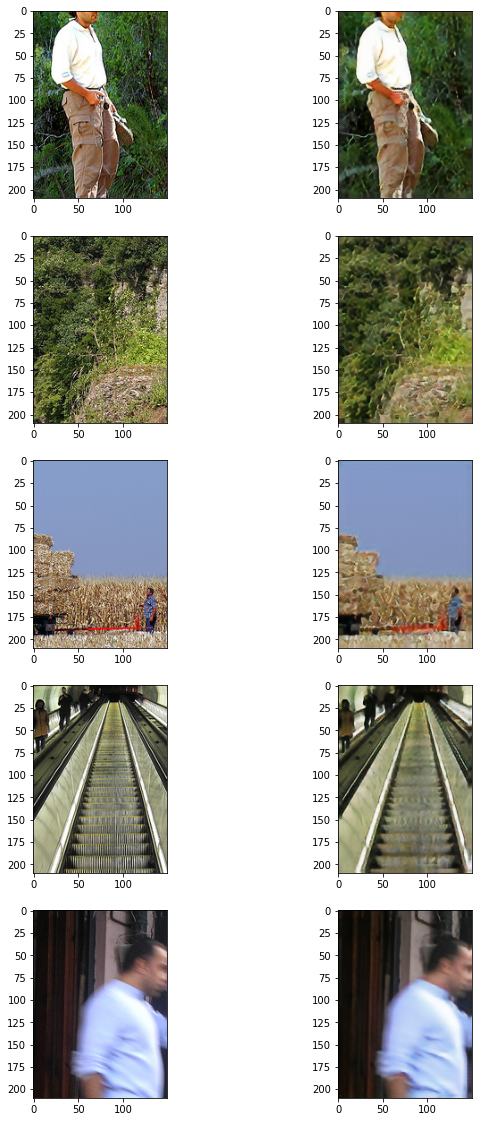

In [23]:
num_images_to_show = 5
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    axarr[i,1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(10)
plt.show()

In [24]:
torch.save(netE.state_dict(), "netE"+str(num_channels_in_encoder)+".model")
torch.save(netG.state_dict(), "netG"+str(num_channels_in_encoder)+".model")

**Use Pretrained Model**

In [417]:
import torch
# load pretrained model
workspace_dir = '.'

E = Encoder().to(device)
E.load_state_dict(torch.load(os.path.join(workspace_dir, 'models/netE8.model'), map_location=torch.device('cpu')))
E.eval()
# E.cuda()

G = Generator().to(device)
G.load_state_dict(torch.load(os.path.join(workspace_dir, 'models/netG8.model'), map_location=torch.device('cpu')))
G.eval()
# G.cuda()

Generator(
  (d_up_conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (3): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  )
  (d_block_1): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
    (3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (d_block_2): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
    (3): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (d_block_3): Sequential(
    (0): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
   

In [399]:
valid_dataset = ImageData(is_train=False)
batch_size=10
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [418]:
print(valid_batch.shape)
encoded_img = E(valid_batch)
# torch.save(encoded_img, "./1c.pt")
print(encoded_img.shape)
reconstructed_img = G(encoded_img)
print(reconstructed_img.shape)

torch.Size([5, 3, 294, 210])
torch.Size([5, 1, 73, 52])
torch.Size([5, 3, 294, 210])


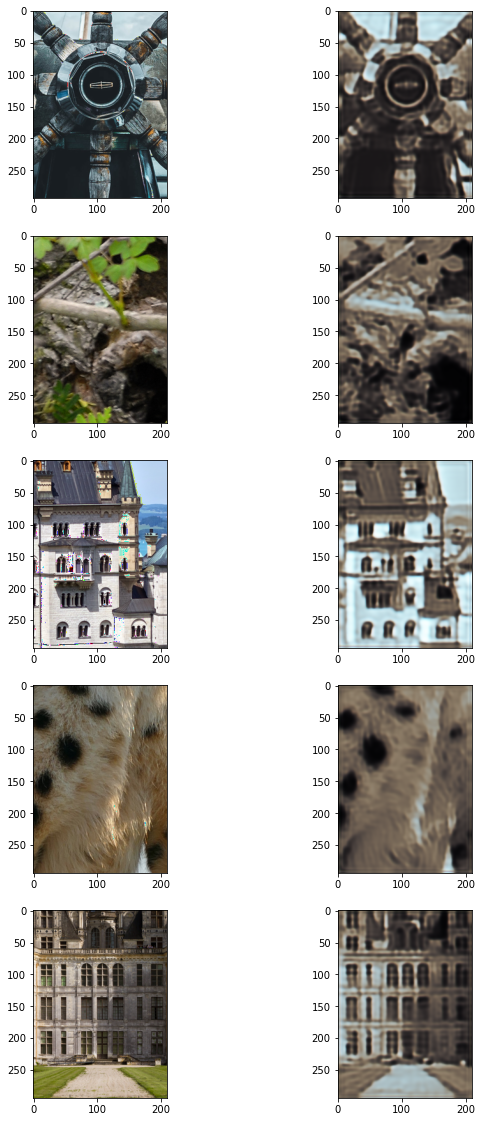

In [419]:
from torch.autograd import Variable
import cv2
import numpy as np
from PIL import Image
import torchvision

num_images_to_show = 10
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    
    validimg = np.array(validimg)
    plt.imsave("valid_net"+str(i)+".png", validimg)
    
    axarr[i,1].imshow(rec_img)
    
    rec_img = np.array(rec_img)
    plt.imsave("rec_netpre8c"+str(i)+".png", rec_img)
    f.set_figheight(20)
    f.set_figwidth(10)
plt.show()